## Import necessary libraries


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle as pkl

## Model_hybride

In [65]:
def Model_Nano1_Hybride(X, t, k, exter, svm_regressor):
    #svm training
    #print("Mean Squared Error:", mse)
    # Parameters
    mumax, Ks, Ysx, Ysp, YsAc, YxAc = k
    a=0.0142
    b=0.3383
    # Variables
    X = np.maximum(X, 0)
    X1, S, Ac, P, V = X

    # Externals
    T = np.interp(t, exter[:, 0], exter[:, 1])
    # Flow of Glucose solution
    if len(exter[:, 0]) == 15:
        if t <= 4.9:
            Fs = 0
        elif 4.9 < t <= 9.2:
            Fs = 0.011 * t + 0.0015
        elif t > 9.2:
            Fs = 0.0006 * t + 0.0015
            mumax = a * T + b
    elif len(exter[:,0]) == 17:
        if t <= 5.1:
            Fs = 0
        elif 5.1 < t <= 8.6:
            Fs = 0.013 * t + 0.0015
            Ysx=0.1
        else:
            Fs = 0.0001 * t + 0.0015
            mumax = a * T + b
            Ysx=0.2572
    
    elif len(exter[:, 0]) == 21 and exter[-1, 0] < 14.92:
        if t <= 6.5:
            Fs = 0
        elif 6.5 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 21 and exter[-1, 0] > 14.92:
        if t <= 7:
            Fs = 0
        elif 7 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b     
    elif len(exter[:, 0]) == 28:
        if t <= 5.55:
            Fs = 0
        elif 5.55 < t <= 9:
            Fs = 0.013 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0003 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 27:
        if t <= 5.5:
            Fs = 0
        elif 5.5 < t <= 11.8:
            Fs = 0.01 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0002 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 25:
        if t <= 5.7:
            Fs = 0
        elif 5.7 < t <= 10:
            Fs = 0.01 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0002 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    # Add more conditions for different lengths of exter data if needed
    
    Sin = 1.43 * 200
    Fsample = 30

    # Constants
    Tref = 37

    # Kinetics
    mu = mumax * S / (Ks + S)
    # State variables

    dVdt = Fs

    rX = mu * X1
    dXdt = rX - dVdt / V * X1

    alpha = 3.35
    gama1 = 0.57
    gama2 = 2.52
    Ap1 = 34.55
    Ap2 = 30.67
    beta = 0.76

    ind = np.interp(t, exter[:, 0], exter[:, 2])
    if ind == 0:
        rP = 0
    elif ind > 0:
        # Implement the model for rP when ind is positive
        T_norm =(T-28)/(37-28)
        mu_norm = (mu-0)/(0.073675586-0)
        d=[[T_norm, mu_norm]]
        rP_norm = svm(svm_regressor,d)
        if rP_norm[0]<0:
            rP_norm[0]=0
        rP_norm=rP_norm[0]
        rP=rP_norm*(0.0408-0)+0

    dPdt = rP*X1 - dVdt / V * P
    rAc = mu * X1
    rS = rX / Ysx - YxAc * X1
    dAcdt = rAc - dVdt / V * Ac
    dSdt = Fs * Sin - S * dVdt / V - rS

    dX = [dXdt, dSdt, dAcdt, dPdt, dVdt]
    return dX


## Train dummy svm (uses the file that ceasar shared)

In [4]:
data = pd.read_excel('DatArticle_orig.xls',header=0)
data=data.drop(0)
data=data[{'Temperature.1', 'mumax.1' , 'qp.1'} ]
X=data[{'Temperature.1', 'mumax.1'}]
y=data['qp.1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm_regressor = SVR(kernel='rbf', C=100)
svm_regressor.fit(X_train, y_train)
y_pred = svm_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.04161413541987465


C:\Users\jiraj\AppData\Local\Temp\ipykernel_24332\3007863566.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data=data[{'Temperature.1', 'mumax.1' , 'qp.1'} ]
C:\Users\jiraj\AppData\Local\Temp\ipykernel_24332\3007863566.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X=data[{'Temperature.1', 'mumax.1'}]


## Load pickle files

In [5]:
with open('lr.pkl', 'rb') as pickle_file:
    lr=pkl.load(pickle_file)
with open('svr.pkl', 'rb') as pickle_file:
    svr=pkl.load(pickle_file)
with open('rf.pkl', 'rb') as pickle_file:
    rf=pkl.load(pickle_file)


C:\Users\jiraj\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\jiraj\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator SVR from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\jiraj\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use a

## Create a function for the svm prediction

In [6]:
def svm(svm_regressor,X):
    y=svm_regressor.predict(X)
    return y

## Run tutorial (used the kinetic parameters from ceasar and br03 experimental data)

In [66]:
#Define parameters from excel file
#k=pd.read_excel('ParametresPo_monod.xls')
k=[0.6794 ,0.0002, 0.2572 ,0.2605, 0.07715, 0.02471]
A3 = pd.read_excel('BR02_for_model.xlsx',header=0)
#drop units row
A3=A3.drop(0)
to3 = A3.iloc[0, 0]
tf3 = A3.iloc[-1, 0]
tspan3 = [to3, tf3]

Gluc3 = A3.iloc[0, 1]
Bio3 = A3.iloc[0, 2]
Ace3 = A3.iloc[0, 4]
V3 = A3.iloc[0, 5]
Pro3 = A3.iloc[0, 3]
x03 = [Bio3, Gluc3, Ace3, Pro3, V3]
Ext3 = A3[['Time', 'Temperature', 'Induction']].values.astype('float64')
#Solve simple model and hybrid model for the protein production
t3 = np.linspace(to3, tf3, num=100)
#result_simple=odeint(Model_Nano1_Temp1, x03, t3, args=(k, Ext3))
result_svr=odeint(Model_Nano1_Hybride,x03, t3, args=(k, Ext3,svr))
result_lr=odeint(Model_Nano1_Hybride,x03, t3, args=(k, Ext3,lr))
result_rf=odeint(Model_Nano1_Hybride,x03, t3, args=(k, Ext3,rf))

## Export simulation points and experimental points

In [28]:
df=pd.DataFrame(data=result_svr,columns=["Biomass_sim", "Glucose_sim", "Acetate_sim", "Protein_sim", "Volume_sim"])
df['time']=t3
target_times=A3['Time'].values
def find_closest_time(target_time):
    return df.iloc[(df['time'] - target_time).abs().idxmin()]

# Create a new DataFrame with rows closest to the target times
result_df = pd.DataFrame([find_closest_time(target_time) for target_time in target_times])
dummy=A3.drop(columns=['Time','Temperature'])
cols=dummy.columns.to_list()
result_df[cols]=dummy.values
result_df=result_df.set_index('time')
result_df.to_csv('BR09_svr.csv')

## Create simple plots

### Protein Production

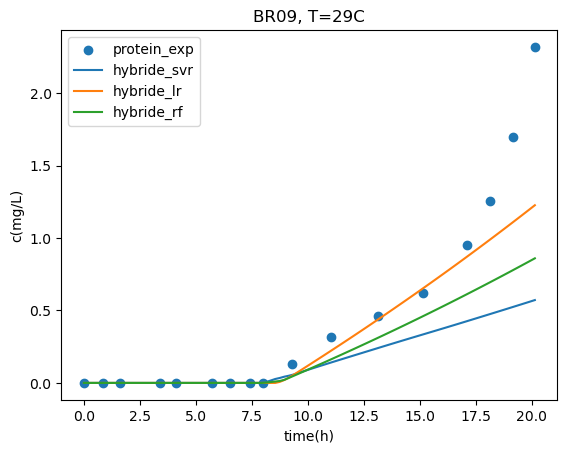

In [67]:
#plt.plot(t3,result_simple[:,0],label='biomass')
#plt.plot(t3,result_simple[:,1],label='glucose')
#plt.plot(t3,result_simple[:,2],label='acetate')
plt.scatter(A3['Time'].values,A3['Protein'].values,label='protein_exp')
plt.plot(t3,result_svr[:,3],label='hybride_svr')
plt.plot(t3,result_lr[:,3],label='hybride_lr')
plt.plot(t3,result_rf[:,3],label='hybride_rf')
plt.xlabel('time(h)')
plt.ylabel('c(mg/L)')
plt.legend()
plt.title('BR09, T=29C')
plt.show()

### Biomass/acetate/gluose plots

Text(0.5, 1.0, 'BR09, T=29C')

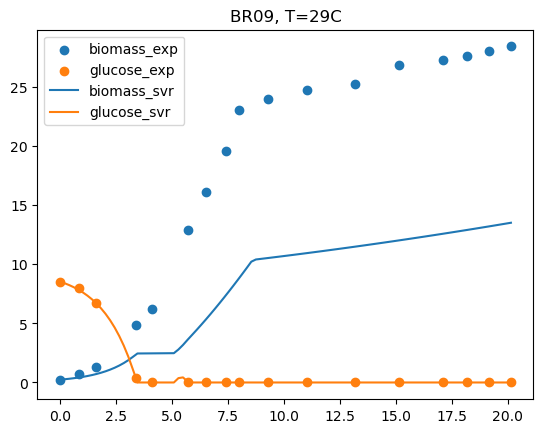

In [68]:
plt.scatter(A3['Time'].values,A3['Biomass'].values,label='biomass_exp')
plt.scatter(A3['Time'].values,A3['Glucose'].values,label='glucose_exp')
plt.plot(t3,result_svr[:,0],label='biomass_svr')
plt.plot(t3,result_svr[:,1],label='glucose_svr')
#plt.plot(t3,result_lr[:,0],label='biomass_lr')
#plt.plot(t3,result_lr[:,1],label='glucose_lr')
#plt.plot(t3,result_rf[:,0],label='biomass_rf')
#plt.plot(t3,result_rf[:,1],label='glucose_rf')
#plt.plot(t3,result_svr[:,2],label='acetate')
plt.legend()
plt.title('BR09, T=29C')

# Model Temp_1 (haven't tested it out yet)

In [53]:
def Model_Nano1_Temp1(X, t, k, exter):
    # Parameters
    mumax, Ks, Ysx, a, b, YxAc = k

    # Variables
    
    #X1, S, Ac, P, V = X
    X = np.maximum(X, 0)
    X1, S, Ac, P, V = X
    # Externals
    T = np.interp(t, exter[:, 0], exter[:, 1])

    if len(exter[:,0]) == 15:
        if t <= 4.9:
            Fs = 0
        elif 4.9 < t <= 9.2:
            Fs = 0.011 * t + 0.0015
        else:
            Fs = 0.0006 * t + 0.0015
            mumax = a * T + b
    elif len(exter[:,0]) == 17:
        if t <= 5.1:
            Fs = 0
        elif 5.1 < t <= 8.6:
            Fs = 0.013 * t + 0.0015
        else:
            Fs = 0.0001 * t + 0.0015
            mumax = a * T + b
    
    elif len(exter[:, 0]) == 21 and exter[0, -1] < 14.92:
        if t <= 6.5:
            Fs = 0
        elif 6.5 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 21 and exter[0, -1] > 14.92:
        if t <= 7:
            Fs = 0
        elif 7 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 21 and exter[0, -1] < 14.92:
        if t <= 6.5:
            Fs = 0
        elif 6.5 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b      
    elif len(exter[:, 0]) == 28:
        if t <= 5.55:
            Fs = 0
        elif 5.55 < t <= 9:
            Fs = 0.013 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0003 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 27:
        if t <= 5.5:
            Fs = 0
        elif 5.5 < t <= 11.8:
            Fs = 0.01 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0002 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 25:
        if t <= 5.7:
            Fs = 0
        elif 5.7 < t <= 10:
            Fs = 0.01 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0002 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    
 # Initialize to 0, replace with conditions

    Sin = 1.43 * 200
    Fsample = 30
    # Constants
    Tref = 37

    # Kinetics
    # Monod with inhibitionof acetic acid
    a=0.02
    b=0.08
    c=4.34
    d=65
    mu = mumax * S / (Ks + S)

    # State variables
    dVdt = Fs
    rX = mu * X1
    dXdt = rX - dVdt / V * X1
    #Luedeking Piret for production of Protein
    alpha = 3.35
    gama1 = 0.57
    gama2 = 2.52
    Ap1 = 34.55
    Ap2 = 30.67
    beta = 0.76
    ind = np.interp(t, exter[:, 0], exter[:, 2])
    if ind == 0:
        rP = 0
    else:
        rP = -alpha * mu + gama1 * np.exp(-Ap1 / T) - gama2 * np.exp(-Ap2 / T) + beta
        rP=rP/1000
    
    dPdt = -rP - dVdt / V * P
    rAc = mu * X1/ YxAc 
    rS = rX / Ysx - YxAc*X1
    dAcdt = rAc - dVdt / V * Ac
    dSdt = Fs * Sin - S * dVdt / V - rS

    dX = [dXdt, dSdt, dAcdt, dPdt, dVdt]
    return dX

## Model Temp1 example

In [ ]:
# Example usage
tspan = np.linspace(0, 20, 100)  # Define the time span
u0 = [1.0, 1.0, 1.0, 1.0, 1.0]  # Initial conditions
k = [0.1, 1, 0.5, 0.4, 0.3, 0.2]  # Example parameter values
exter = np.array([[0, 37], [10, 38], [20, 39]])  # Example external data
result = odeint(Model_Nano1_Temp1, u0, tspan, args=(k,exter))
plt.plot(tspan,result[:,0],label='biomass')
plt.plot(tspan,result[:,1],label='glucose')
plt.plot(tspan,result[:,2],label='acetate')
plt.plot(tspan,result[:,3],label='protein')
plt.xlabel('time(h)')
plt.ylabel('c(mol/L)')
plt.legend()
plt.show()
exter

In [72]:
dummy=

#ummy.values


Index(['Glucose', 'Biomass', 'Protein', 'Acetate', 'Vreal', 'Induction'], dtype='object')

In [33]:
f=A3['Time'].values
f


array([0, 0.8333333333333357, 1.6166666666666654, 3.383333333333338,
       4.116666666666669, 5.733333333333334, 6.533333333333333,
       7.400000000000004, 8.000000000000002, 9.283333333333333,
       11.033333333333333, 13.15, 15.150000000000002, 17.100000000000005,
       18.150000000000002, 19.166666666666668, 20.133333333333336],
      dtype=object)

In [49]:
result_df.set_index('time')

,Biomass,Glucose,Acetate,Protein,Volume
time,,,,,
0.000000,0.237527,8.530000,0.061000,0.000000,1.500919
0.813468,0.412789,7.854949,0.236263,0.000000,1.500919
1.626936,0.717371,6.681808,0.540844,0.000000,1.500919
3.457239,2.452488,0.000002,2.275962,0.000000,1.500919
4.067340,2.462016,0.000002,2.285489,0.000000,1.500919
5.694276,3.608198,7.396376,3.436542,0.000000,1.543507
6.507744,6.014423,15.675860,5.849779,0.000000,1.609246
7.321212,9.990786,19.437401,9.833412,0.000000,1.683587
7.931313,14.590056,16.936461,14.438220,0.000000,1.744988


In [82]:
result_df

,Biomass,Glucose,Acetate,Protein,Volume,time,Vreal,Induction
0,0.237527,8.53,0.061,0,1.500919,0.000000,1.500919,0
4,0.758194,7.95,0.132,0,1.500919,0.813468,1.478419,0
8,1.282143,6.76,0.171,0,1.500919,1.626936,1.456207,0
17,4.88775,0.365,0.227,0,1.500919,3.457239,1.461191,0
20,6.175,0.011,0.281,0,1.500919,4.067340,1.483981,0
28,12.871429,0,0,0,1.543507,5.694276,1.55967,0
32,16.071429,0,0,0,1.609246,6.507744,1.622434,0
36,19.55,0.01,0,0,1.683587,7.321212,1.713444,0
39,23.071429,0,0,0,1.744988,7.931313,1.779788,0
46,23.982143,0,0,0.13101,1.819654,9.354882,1.738042,1


In [14]:
result_df

,Biomass_sim,Glucose_sim,Acetate_sim,Protein_sim,Volume_sim,Glucose,Biomass,Protein,Acetate,Vreal,Induction
time,,,,,,,,,,,
0.000000,0.237527,8.530000,0.061000,0.000000,1.500919,8.53,0.237527,0,0.061,1.500919,0
0.813468,0.412789,7.854949,0.236263,0.000000,1.500919,7.95,0.758194,0,0.132,1.478419,0
1.626936,0.717371,6.681808,0.540844,0.000000,1.500919,6.76,1.282143,0,0.171,1.456207,0
3.457239,2.452488,0.000002,2.275962,0.000000,1.500919,0.365,4.88775,0,0.227,1.461191,0
4.067340,2.462016,0.000002,2.285489,0.000000,1.500919,0.011,6.175,0,0.281,1.483981,0
5.694276,3.608198,7.396376,3.436542,0.000000,1.543507,0,12.871429,0,0,1.55967,0
6.507744,6.014423,15.675860,5.849779,0.000000,1.609246,0,16.071429,0,0,1.622434,0
7.321212,9.990786,19.437401,9.833412,0.000000,1.683587,0.01,19.55,0,0,1.713444,0
7.931313,14.590056,16.936461,14.438220,0.000000,1.744988,0,23.071429,0,0,1.779788,0


In [34]:
T = np.interp(t3, A3[:, 0], A3[:, 1])

InvalidIndexError: (slice(None, None, None), 0)